# UFC Case Study Notebook

## Importing libraries

In [1159]:
#from collections import Counter
import json
from datetime import datetime
from collections import defaultdict
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import kagglehub
from jinja2 import Environment, FileSystemLoader

## Util functions

In [1160]:
def human_readable_date(date):
    # usage example d = human_readable_date(datetime.today())
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")  # ou "%d/%m/%Y" se for BR

    day = date.day
    year = date.year
    month = date.strftime("%B")

    # Sufixos: st, nd, rd, th
    if 11 <= day <= 13:
        suffix = "th"
    else:
        last_digit = day % 10
        suffix = {1: "st", 2: "nd", 3: "rd"}.get(last_digit, "th")

    return f"{month} {day}{suffix}, {year}"

def human_readable_duration(seconds: int) -> str:
    if seconds < 0:
        raise ValueError("Duration cannot be negative")

    minutes, sec = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)

    parts = []
    if hours:
        parts.append(f"{hours} hour" + ("s" if hours != 1 else ""))
    if minutes:
        parts.append(f"{minutes} minute" + ("s" if minutes != 1 else ""))
    if not parts:
        parts.append("less than a minute")

    return " and ".join(parts)

def float_to_min_sec(time_in_minutes: float) -> str:
    """
    Converts a value in minutes (float) to a string in the format 'MM:SS'
    Eg: 3.75 -> '3:45'
    """
    total_seconds = int(round(time_in_minutes * 60))
    minutes = total_seconds // 60
    seconds = total_seconds % 60
    return f"{minutes} mins {seconds:02d} secs"


## Raw data fetch

In [1161]:
path = kagglehub.dataset_download("neelagiriaditya/ufc-datasets-1994-2025")
print("Path to dataset files:", path)

data_folder = "/UFC DATASETS/"

raw_event_details = pd.read_csv(path + data_folder + "event_details.csv", parse_dates=["date"])
raw_figther_details = pd.read_csv(path + data_folder + "fighter_details.csv", parse_dates=["dob"])
raw_fight_details = pd.read_csv(path + data_folder + "fight_details.csv")
raw_ufc_details = pd.read_csv(path + data_folder + "UFC.csv", parse_dates=["date", "r_dob", "b_dob"])

report_data = {}

Path to dataset files: /Users/joaogouveiaml/.cache/kagglehub/datasets/neelagiriaditya/ufc-datasets-1994-2025/versions/2


## Data basic exploration

### Event details exploration

In [1162]:
raw_event_details.head()

,event_id,fight_id,date,location,winner,winner_id
0,421ccfc6ddb17958,12cedec11b37ddc0,2025-08-16,"Chicago, Illinois, USA",Khamzat Chimaev,767755fd74662dbf
1,421ccfc6ddb17958,9fa6a029f7f8241c,2025-08-16,"Chicago, Illinois, USA",Lerone Murphy,396fe87b84ac2e1c
2,421ccfc6ddb17958,42585ce706c086de,2025-08-16,"Chicago, Illinois, USA",Carlos Prates,7ee0fd831c0fe7c3
3,421ccfc6ddb17958,9939d7073462e07e,2025-08-16,"Chicago, Illinois, USA",Michael Page,a67d071163962af8
4,421ccfc6ddb17958,82338ba457fbe87f,2025-08-16,"Chicago, Illinois, USA",Tim Elliott,c96d9178c9ed9e62


In [1163]:
raw_event_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8312 entries, 0 to 8311
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   event_id   8312 non-null   object        
 1   fight_id   8312 non-null   object        
 2   date       8312 non-null   datetime64[ns]
 3   location   8312 non-null   object        
 4   winner     8165 non-null   object        
 5   winner_id  8165 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 389.8+ KB


### Fighter details exploration

In [1164]:
raw_figther_details.head()

,id,name,nick_name,wins,losses,draws,height,weight,reach,stance,dob,splm,str_acc,sapm,str_def,td_avg,td_avg_acc,td_def,sub_avg
0,231926533134ec1f,Justin Buchholz,NaN,15,10,0,182.88,70.31,185.42,Orthodox,1983-08-22,2.35,26,4.14,51,0.00,0,33,0.8
1,f782f953bfe7b5f2,Jonathan Micallef,The Captain,8,1,0,182.88,77.11,195.58,Southpaw,1999-03-05,4.77,43,4.00,58,0.83,50,50,0.8
2,2e04a3b4a2011b97,Roland Payne,NaN,0,1,0,175.26,92.99,NaN,Orthodox,NaT,0.00,0,0.00,0,0.00,0,0,0.0
3,29f935654825331b,Chris Sanford,NaN,5,1,0,180.34,83.91,NaN,Orthodox,1968-03-12,0.23,50,3.22,17,0.00,0,0,3.5
4,15df64c02b6b0fde,Danny Abbadi,The Assassin,4,6,0,180.34,70.31,NaN,Orthodox,1983-07-03,3.29,38,4.41,57,0.00,0,77,0.0


In [1165]:
raw_figther_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2606 entries, 0 to 2605
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          2606 non-null   object        
 1   name        2606 non-null   object        
 2   nick_name   1688 non-null   object        
 3   wins        2606 non-null   int64         
 4   losses      2606 non-null   int64         
 5   draws       2606 non-null   int64         
 6   height      2585 non-null   float64       
 7   weight      2588 non-null   float64       
 8   reach       1951 non-null   float64       
 9   stance      2529 non-null   object        
 10  dob         2450 non-null   datetime64[ns]
 11  splm        2606 non-null   float64       
 12  str_acc     2606 non-null   int64         
 13  sapm        2606 non-null   float64       
 14  str_def     2606 non-null   int64         
 15  td_avg      2606 non-null   float64       
 16  td_avg_acc  2606 non-nul

### Fight details exploration

In [1166]:
raw_fight_details.head()

,event_name,event_id,fight_id,r_name,r_id,b_name,b_id,division,title_fight,method,...,b_clinch_acc,b_ground_landed,b_ground_atmpted,b_ground_acc,b_landed_head_per,b_landed_body_per,b_landed_leg_per,b_landed_dist_per,b_landed_clinch_per,b_landed_ground_per
0,UFC 319: Du Plessis vs. Chimaev,421ccfc6ddb17958,82338ba457fbe87f,Tim Elliott,c96d9178c9ed9e62,Kai Asakura,d33da8a3d82bdb62,flyweight,0,Submission,...,NaN,0.0,0.0,NaN,80.0,14.0,4.0,100.0,0.0,0.0
1,UFC 319: Du Plessis vs. Chimaev,421ccfc6ddb17958,1d8dc0fb5d47357f,Chase Hooper,971246648e162f0d,Alexander Hernandez,262a7d06203657e6,lightweight,0,KO/TKO,...,NaN,4.0,5.0,80.0,82.0,17.0,0.0,76.0,0.0,23.0
2,UFC 319: Du Plessis vs. Chimaev,421ccfc6ddb17958,5b880d10b0ed7acc,Gerald Meerschaert,6ac9bc2953c47345,Michal Oleksiejczuk,0d65c432720accb9,middleweight,0,KO/TKO,...,NaN,12.0,20.0,60.0,78.0,21.0,0.0,47.0,0.0,52.0
3,UFC 319: Du Plessis vs. Chimaev,421ccfc6ddb17958,42585ce706c086de,Geoff Neal,b997be68943010fc,Carlos Prates,7ee0fd831c0fe7c3,welterweight,0,KO/TKO,...,0.0,0.0,0.0,NaN,53.0,25.0,21.0,100.0,0.0,0.0
4,UFC 319: Du Plessis vs. Chimaev,421ccfc6ddb17958,12cedec11b37ddc0,Dricus Du Plessis,0d7b51c9d2649a6e,Khamzat Chimaev,767755fd74662dbf,middleweight,1,Decision - Unanimous,...,NaN,25.0,28.0,89.0,75.0,8.0,16.0,32.0,0.0,67.0


In [1167]:
raw_fight_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8312 entries, 0 to 8311
Data columns (total 86 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   event_name           8312 non-null   object 
 1   event_id             8312 non-null   object 
 2   fight_id             8312 non-null   object 
 3   r_name               8312 non-null   object 
 4   r_id                 8312 non-null   object 
 5   b_name               8312 non-null   object 
 6   b_id                 8312 non-null   object 
 7   division             8312 non-null   object 
 8   title_fight          8312 non-null   int64  
 9   method               8312 non-null   object 
 10  finish_round         8312 non-null   int64  
 11  match_time_sec       8312 non-null   int64  
 12  total_rounds         8281 non-null   float64
 13  referee              8286 non-null   object 
 14  r_kd                 8291 non-null   float64
 15  r_sig_str_landed     8291 non-null   f

# Fight details initial cleaning

> Only weight categories with short names (up to two words) and divisions with no numbers in the name were considered, as long names suggest personalized, inconsistent, or poorly categorized divisions in the raw data. Also Superfight Championship and Open Weight were removed because they were disputed only in, respectively 2 and 4 years

In [1168]:
filtered_raw_fight_details = raw_fight_details[
    (raw_fight_details["division"].str.split().str.len() <= 2) &
    (~raw_fight_details["division"].str.contains(r'\d', regex=True)) &    (~raw_fight_details["division"].str.contains(r'open weight|superfight championship', regex=True))
]

In [1169]:
# Filtering just the UFC events data
ufc_fights = raw_fight_details[raw_fight_details["event_name"].str.contains(r"\bUFC\b", case=False, na=False)]
ufc_events = raw_event_details[raw_event_details["event_id"].isin(ufc_fights["event_id"])]
ufc_fighters = raw_figther_details[raw_figther_details["id"].isin(
    pd.concat([ufc_fights["r_id"], ufc_fights["b_id"]]).unique()
)]

#### Creating helper fields

In [1170]:
winner_lookup = raw_ufc_details[["fight_id", "winner_id"]].drop_duplicates("fight_id")
ufc_fights = (
    ufc_fights
    .merge(winner_lookup, on="fight_id", how="left", validate="m:1")
)

wins_per_fighter = (
    ufc_fights.groupby("winner_id")
    .size()
    .reset_index(name="ufc_wins")
)

ufc_fighters = ufc_fighters.merge(
    wins_per_fighter,
    left_on="id",
    right_on="winner_id",
    how="left"
)

ufc_fighters["ufc_wins"] = ufc_fighters["ufc_wins"].fillna(0).astype(int)


# dob_str

ufc_fighters["dob_str"] = ufc_fighters["dob"].dt.strftime('%Y-%m-%d')

# fight date

ufc_fights = ufc_fights.merge(
    ufc_events[['event_id', 'date']],
    on='event_id',
    how='left'
)

#last fight date

r_fights = ufc_fights[['fight_id', 'date', 'r_id']].rename(columns={'r_id': 'fighter_id'})
b_fights = ufc_fights[['fight_id', 'date', 'b_id']].rename(columns={'b_id': 'fighter_id'})

all_fights = pd.concat([r_fights, b_fights])

last_fight_dates = all_fights.groupby('fighter_id')['date'].max().reset_index()
last_fight_dates = last_fight_dates.rename(columns={'date': 'last_ufc_fight_date'})

ufc_fighters = ufc_fighters.merge(last_fight_dates, left_on='id', right_on='fighter_id', how='left')

# last ufc_fight_str

ufc_fighters["last_ufc_fight_date_str"] = ufc_fighters["last_ufc_fight_date"].dt.strftime('%Y-%m-%d')


In [1171]:
ufc_fights = ufc_fights.drop_duplicates(subset="fight_id").reset_index(drop=True)

# 1. Description Reports

## Historical overview of the UFC

### Overview information

In [1172]:

total_fights = ufc_fights["fight_id"].nunique()
total_events = ufc_fights["event_id"].nunique()
total_fighters = (
    ufc_fights[["r_id", "b_id"]]
    .melt(value_name="fighter_id")
    ["fighter_id"]
    .nunique()
)

decision_method_mask = raw_fight_details["method"].str.contains("decision", case=False, na=False)
fights_end_in_decision_count = raw_fight_details.loc[decision_method_mask, "fight_id"].nunique()
fights_end_in_decision_perc = fights_end_in_decision_count / total_fights

ufc_events["year"] = ufc_events["date"].dt.year
events_by_year = (
    ufc_events
        .groupby("year")["event_id"]
        .nunique() 
        .reset_index(name="num_of_events")
        .sort_values(by="num_of_events", ascending=False)
)

# My approach
#avg_fights_per_event = (
#    ufc_events
#        .groupby("event_id")["fight_id"]
#        .nunique() 
#        .reset_index(name="num_of_fights")
#)["num_of_fights"].mean()

# LLM suggestion
avg_fights_per_event = (
    ufc_events
        .groupby("event_id")["fight_id"]
        .nunique()
        .mean()
)

locations_df = ufc_events[["location"]].copy()
locations_df["country"] = locations_df.location.str.split(",").str[-1].str.strip()
locations_df["city"] = locations_df.location.str.split(",").str[0].str.strip()

report_data["total_fights"] = total_fights
report_data["total_events"] = total_events
report_data["total_fighters"] = total_fighters
report_data["decision_ending_perc"] = round(fights_end_in_decision_perc * 100, 2)
report_data["year_with_most_events"] = int(events_by_year.iloc[0]["year"])
report_data["avg_fights_per_event"] = round(float(avg_fights_per_event), 2)
report_data["num_of_cities"] = locations_df["city"].nunique()
report_data["num_of_countries"] = locations_df["country"].nunique()

/var/folders/y2/th9j6g7n1wgghjg95sgj0cqr0000gq/T/ipykernel_97586/2302229121.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_events["year"] = ufc_events["date"].dt.year


### Events by year

In [1173]:
# fights_by_year = Counter(raw_event_details["date"].map(lambda d: d.year)) my approach, more python way
# One problem with my approach is that I'll have to make a bunch of conversions in order to plot the data
events_by_year = ufc_events["date"].dt.year.value_counts().sort_index() # LLM approach suggestion, more pandas way
report_data["events_per_year"] = events_by_year.to_dict()

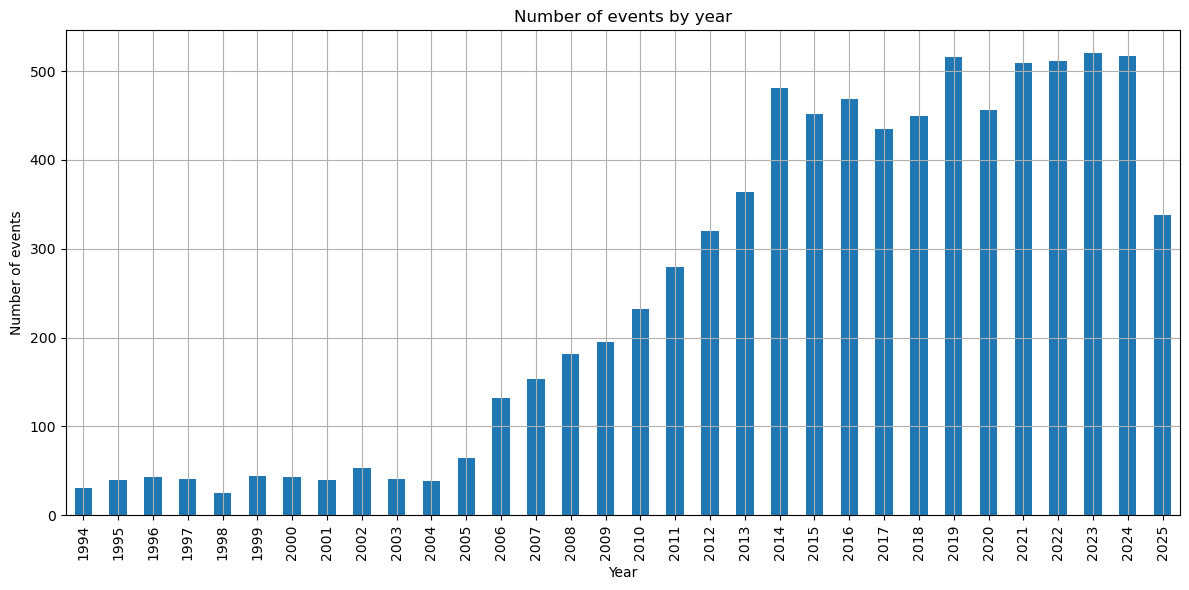

In [1174]:
events_by_year.plot(kind="bar", figsize=(12, 6), title="Number of events by year")
plt.xlabel("Year")
plt.ylabel("Number of events")
plt.grid(True)
plt.tight_layout()
plt.show()

> We can see from the chart that the number of events in the year increased significantly from 2005 onwards

### Top 5 Cities and Countries with more events

In [1175]:
event_location = ufc_events["location"].copy()

split_location = event_location.str.split(',', expand=True).apply(lambda col: col.str.strip())

# Creating new data frame
event_location_df = pd.DataFrame()
event_location_df["city"] = split_location[0]
event_location_df["country"] = split_location.apply(
    lambda row: row.iloc[-2] if pd.isna(row.iloc[-1]) else row.iloc[-1],
    axis=1
)

In [1176]:
countries_num_of_events = event_location_df["country"].value_counts().sort_values(ascending=False).reset_index()
countries_num_of_events["position"] = range(1, len(countries_num_of_events) + 1)
countries_num_of_events.head(5)

,country,count,position
0,USA,5515,1
1,Brazil,471,2
2,Canada,413,3
3,United Kingdom,338,4
4,United Arab Emirates,252,5


In [1177]:
report_data["top_5_countries_with_more_events"] = countries_num_of_events.head(5).to_dict(orient="records")

In [1178]:
cities_num_of_events = event_location_df["city"].value_counts().sort_values(ascending=False).reset_index()
cities_num_of_events["position"] = range(1, len(cities_num_of_events) + 1)
cities_num_of_events["image"] = cities_num_of_events["position"].apply(lambda x: f"images/city{x}.jpg")
cities_num_of_events.head(5)

,city,count,position,image
0,Las Vegas,2521,1,images/city1.jpg
1,Abu Dhabi,252,2,images/city2.jpg
2,London,183,3,images/city3.jpg
3,Rio de Janeiro,147,4,images/city4.jpg
4,Newark,127,5,images/city5.jpg


In [1179]:
cities_num_of_events_top_five = cities_num_of_events.head(5)

report_data["top_5_cities_with_more_events"] = cities_num_of_events.head(5).to_dict(orient="records")

### Number of fights by weight category over time

In [1180]:
categories_fights = pd.merge(
    filtered_raw_fight_details[["event_id", "division"]],
    raw_event_details[["event_id", "date"]],
    on="event_id",
    how="inner"
).drop(["event_id"], axis = 1)

In [1181]:
categories_fights["year"] = pd.to_datetime(categories_fights["date"]).dt.year

In [1182]:
categories_fights = categories_fights.drop(["date"], axis = 1)

In [1183]:
fights_per_year_division = (
    categories_fights
    .groupby(["year", "division"])
    .size()
    .reset_index(name="num_fights")
)

fights_per_year_division

,year,division,num_fights
0,1997,heavyweight,185
1,1997,light heavyweight,7
2,1997,lightweight,99
3,1998,heavyweight,60
4,1998,light heavyweight,25
...,...,...,...
265,2025,welterweight,447
266,2025,women's bantamweight,149
267,2025,women's featherweight,9
268,2025,women's flyweight,220


#### ChartJS formatting transformation

In [1184]:

data = fights_per_year_division.to_dict(orient="records")

# Reorganize per division
divisions = defaultdict(list)
years = sorted(set(d["year"] for d in data))

for division in sorted(set(d["division"] for d in data)):
    for year in years:
        fight = next((x["num_fights"] for x in data if x["year"] == year and x["division"] == division), 0)
        divisions[division].append(fight)

dist_fights_per_weight_chart_data = {
    "labels": years,
    "datasets": [
        {
            "label": division,
            "data": fights,
        }
        for division, fights in divisions.items()
    ]
}

report_data["fights_per_year_division"] = json.dumps(dist_fights_per_weight_chart_data)

## General fight statistics

### Ratio of wins by knockout, submission, and decision

In [1185]:
methods = filtered_raw_fight_details["method"]
methods.value_counts()

method
Decision - Unanimous       2954
KO/TKO                     2542
Submission                 1541
Decision - Split            790
Decision - Majority          95
TKO - Doctor's Stoppage      92
Overturned                   58
Could Not Continue           30
DQ                           23
Name: count, dtype: int64

In [1186]:
ko_submission_decision_methods = filtered_raw_fight_details[
    filtered_raw_fight_details["method"].str.contains("KO/TKO|Submission|Decision", na=False)
]

In [1187]:
ko_submission_decision_methods["method"].value_counts()

method
Decision - Unanimous    2954
KO/TKO                  2542
Submission              1541
Decision - Split         790
Decision - Majority       95
Name: count, dtype: int64

#### Groupping decision method variations

In [1188]:
ko_submission_decision_methods["method_grouped"] = np.where(
    ko_submission_decision_methods["method"].str.contains("Decision", na=False),
    "Decision",
    ko_submission_decision_methods["method"]
)

/var/folders/y2/th9j6g7n1wgghjg95sgj0cqr0000gq/T/ipykernel_97586/113718741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ko_submission_decision_methods["method_grouped"] = np.where(


In [1189]:
ko_submission_decision_methods["method_grouped"].value_counts()

method_grouped
Decision      3839
KO/TKO        2542
Submission    1541
Name: count, dtype: int64

#### Decision methods to chartjs and stats

In [1190]:
report_data["ko_submission_decision_methods"] = {}
chart_data = ko_submission_decision_methods["method_grouped"].value_counts().to_dict()
report_data["ko_submission_decision_methods"]["chart"] = chart_data

vals_sum = sum(list(chart_data.values()))

def apply_perc(n):
    return round(n/vals_sum * 100, 2)
report_data["ko_submission_decision_methods"]["props"] = list(map(apply_perc, list(chart_data.values())))

### Average fight statistics

In [1191]:
avg_fight_stats = ufc_fights.copy()
avg_fight_duration = avg_fight_stats["match_time_sec"].mean() / 60
avg_fight_stats["total_str_landed"] = avg_fight_stats["b_total_str_landed"] + avg_fight_stats["r_total_str_landed"]
avg_str_landed = avg_fight_stats["total_str_landed"].mean()
avg_fight_stats["total_td_landed"] = avg_fight_stats["b_td_landed"] + avg_fight_stats["r_td_landed"]
avg_td_landed = avg_fight_stats["total_td_landed"].mean()
report_data["avg_fight_statistics"] = {}
report_data["avg_fight_statistics"]["avg_fight_duration"] = float_to_min_sec(round(float(avg_fight_duration),2))
report_data["avg_fight_statistics"]["avg_str_landed"] = round(float(avg_str_landed),2)
report_data["avg_fight_statistics"]["avg_td_landed"] = round(float(avg_td_landed),2)

### Average duration of fights by category

In [1192]:
avg_duration_per_division = (
    filtered_raw_fight_details
    .groupby("division")["match_time_sec"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

In [1193]:
avg_duration_per_division

,division,match_time_sec
0,interim middleweight,300.000000
1,interim welterweight,298.000000
2,interim featherweight,286.500000
3,super heavyweight,274.000000
4,interim flyweight,274.000000
5,women's flyweight,259.992308
6,women's strawweight,256.324638
7,interim lightweight,253.666667
8,women's featherweight,250.724138
9,women's bantamweight,247.469298


In [1194]:
avg_duration_per_division["humanized"] = (
    avg_duration_per_division["match_time_sec"].apply(human_readable_duration)
)
avg_duration_per_division

,division,match_time_sec,humanized
0,interim middleweight,300.000000,5.0 minutes
1,interim welterweight,298.000000,4.0 minutes
2,interim featherweight,286.500000,4.0 minutes
3,super heavyweight,274.000000,4.0 minutes
4,interim flyweight,274.000000,4.0 minutes
5,women's flyweight,259.992308,4.0 minutes
6,women's strawweight,256.324638,4.0 minutes
7,interim lightweight,253.666667,4.0 minutes
8,women's featherweight,250.724138,4.0 minutes
9,women's bantamweight,247.469298,4.0 minutes


In [1195]:
report_data["duration_by_weight_class"] = avg_duration_per_division.to_dict(orient="records")

### Most common submission techniques

> Although the initial objective included analyzing the most common submission techniques, the dataset used does not specify the type of submission (e.g., rear naked choke, triangle choke, kimura). Therefore, this analysis could not be performed with the available data.

### Average strikes per minute and per round

In [1196]:
raw_ufc_details.head(5)

,event_id,event_name,date,location,fight_id,division,title_fight,method,finish_round,match_time_sec,...,b_splm,b_str_acc,b_sapm,b_str_def,b_td_avg,b_td_avg_acc,b_td_def,b_sub_avg,winner,winner_id
0,421ccfc6ddb17958,UFC 319: Du Plessis vs. Chimaev,2025-08-16,"Chicago, Illinois, USA",82338ba457fbe87f,flyweight,0,Submission,2,279,...,2.40,58,4.52,38,0.00,0,57,0.0,Tim Elliott,c96d9178c9ed9e62
1,421ccfc6ddb17958,UFC 319: Du Plessis vs. Chimaev,2025-08-16,"Chicago, Illinois, USA",1d8dc0fb5d47357f,lightweight,0,KO/TKO,1,298,...,4.38,40,4.62,57,1.24,36,71,0.1,Alexander Hernandez,262a7d06203657e6
2,421ccfc6ddb17958,UFC 319: Du Plessis vs. Chimaev,2025-08-16,"Chicago, Illinois, USA",5b880d10b0ed7acc,middleweight,0,KO/TKO,1,183,...,5.27,51,4.51,59,1.05,43,48,0.0,Michal Oleksiejczuk,0d65c432720accb9
3,421ccfc6ddb17958,UFC 319: Du Plessis vs. Chimaev,2025-08-16,"Chicago, Illinois, USA",42585ce706c086de,welterweight,0,KO/TKO,1,299,...,3.60,54,4.79,48,0.25,100,83,0.0,Carlos Prates,7ee0fd831c0fe7c3
4,421ccfc6ddb17958,UFC 319: Du Plessis vs. Chimaev,2025-08-16,"Chicago, Illinois, USA",12cedec11b37ddc0,middleweight,1,Decision - Unanimous,5,300,...,5.36,58,3.25,41,4.31,46,100,2.8,Khamzat Chimaev,767755fd74662dbf


#### Average strikes per minute

The main formula to calculate this is 

total strikes landed / (match_time_sec / 60)

for this metric I'll consider only complete fights, or, fights that last more than 300 sec or 5 min

In [1197]:
avg_strikes_per_min_ckp = raw_ufc_details.copy()
avg_strikes_per_min_ckp = avg_strikes_per_min_ckp[
    avg_strikes_per_min_ckp["match_time_sec"] > 300
]

In [1198]:
avg_strikes_per_min_ckp["avg_str_min"] = (avg_strikes_per_min_ckp["b_total_str_landed"] + avg_strikes_per_min_ckp["r_total_str_landed"]) / (avg_strikes_per_min_ckp["match_time_sec"] / 60) 

In [1199]:
avg_strikes_per_min_ckp.head(5)

,event_id,event_name,date,location,fight_id,division,title_fight,method,finish_round,match_time_sec,...,b_str_acc,b_sapm,b_str_def,b_td_avg,b_td_avg_acc,b_td_def,b_sub_avg,winner,winner_id,avg_str_min
8035,a7b48e18ca27795d,UFC 20: Battle for the Gold,1999-05-07,"Birmingham, Alabama, USA",a3fe8217502c42a4,heavyweight,0,Submission,1,388,...,0,0.00,0,0.00,0,0,0.0,Pete Williams,6291ac0a3726732f,6.185567
8055,a220be6d41d6f97d,UFC 19: Ultimate Young Guns,1999-03-05,"Bay St. Louis, Mississippi, USA",c03d0d781df4ad2a,middleweight,0,KO/TKO,1,596,...,32,1.36,72,0.39,50,88,0.0,Tito Ortiz,2f732dd9210d301f,10.167785
8056,a220be6d41d6f97d,UFC 19: Ultimate Young Guns,1999-03-05,"Bay St. Louis, Mississippi, USA",b26c2f616c9436fb,middleweight,0,Submission,1,720,...,35,2.71,56,0.44,75,81,0.0,Jeremy Horn,8d26912cd2aeb366,5.916667
8062,c9bbf1a0285a8076,UFC 18: The Road to the Heavyweight Title,1999-01-08,"New Orleans, Louisiana, USA",fb8e8d1a734b6fe8,middleweight,0,Submission,1,477,...,0,0.00,0,0.00,0,0,0.0,Evan Tanner,8f2d9ee27f206f1f,6.918239
8066,c9bbf1a0285a8076,UFC 18: The Road to the Heavyweight Title,1999-01-08,"New Orleans, Louisiana, USA",0cf7636471fc5e45,lightweight,0,KO/TKO,1,412,...,0,0.00,0,0.00,0,0,0.0,Laverne Clark,1c2f2571b18791b6,5.097087


#### Average strikes per round

The main formula to calculate this is 

total strikes landed / total_rounds

for this metric I'll consider only complete fights, or, fights that last more than than 300 sec or 5 min

In [1200]:
avg_strikes_per_min_ckp["avg_str_rnd"] = (avg_strikes_per_min_ckp["b_total_str_landed"] + avg_strikes_per_min_ckp["r_total_str_landed"]) /  avg_strikes_per_min_ckp["finish_round"]

In [1201]:
avg_strikes_per_min_ckp.head(5)

top_strike_fights = avg_strikes_per_min_ckp[["event_name", "date", "location", "division", "method", "match_time_sec", "b_name", "r_name", "avg_str_min", "avg_str_rnd"]]
top_strike_fights = top_strike_fights.head(5)
top_strike_fights["avg_str_min"] = round(top_strike_fights["avg_str_min"],2)
top_strike_fights["avg_str_rnd"] = avg_strikes_per_min_ckp["avg_str_rnd"]

top_strike_fights_top_five = top_strike_fights.reset_index(drop=True)
top_strike_fights_top_five["position"] = range(1, len(top_strike_fights_top_five) + 1)
top_strike_fights_top_five["r_image"] = top_strike_fights_top_five["position"].apply(lambda x: f"images/fighter{x}_1.jpg")
top_strike_fights_top_five["b_image"] = top_strike_fights_top_five["position"].apply(lambda x: f"images/fighter{x}_2.jpg")

report_data["top_strike_fights"] = top_strike_fights_top_five.to_dict(orient="records")

## Fighter Statistics

### Top 5 fighters with the most UFC wins

In [1202]:
top_5_ufc_winners = ufc_fighters.nlargest(5, "ufc_wins").head(5).copy()
top_5_ufc_winners = top_5_ufc_winners.reset_index(drop=True)
top_5_ufc_winners["image"] = [
    f"images/top_5_winners_fighter_{i+1}.jpg" for i in range(len(top_5_ufc_winners))
]
interest_columns = ["name", "nick_name", "ufc_wins", "wins", "losses", "draws", "height", "weight", "reach" ,"dob_str", "image", "last_ufc_fight_date_str"]
report_data["top_5_ufc_winners"] = top_5_ufc_winners[interest_columns].to_dict(orient="records")

top_5_ufc_winners[interest_columns]

,name,nick_name,ufc_wins,wins,losses,draws,height,weight,reach,dob_str,image,last_ufc_fight_date_str
0,Jim Miller,A-10,27,38,19,0,172.72,70.31,180.34,1983-08-30,images/top_5_winners_fighter_1.jpg,2025-04-12
1,Neil Magny,The Haitian Sensation,23,30,14,0,190.50,77.11,203.20,1987-08-03,images/top_5_winners_fighter_2.jpg,2025-08-02
2,Andrei Arlovski,The Pitbull,23,34,24,0,190.50,108.86,195.58,1979-02-04,images/top_5_winners_fighter_3.jpg,2024-06-29
3,Donald Cerrone,Cowboy,23,36,17,0,185.42,70.31,185.42,1983-03-29,images/top_5_winners_fighter_4.jpg,2022-07-02
4,Jon Jones,Bones,22,28,1,0,193.04,112.49,213.36,1987-07-19,images/top_5_winners_fighter_5.jpg,2024-11-16


### Top 5 fighters with the highest KO rate

In [1203]:
# filtering fights with a winner
df_winners = ufc_fights[ufc_fights["winner_id"].notna()].copy()

# new column to mark victories as KO/TKO
df_winners["is_ko"] = df_winners["method"].str.contains("KO", case=False, na=False)

# counting KO/TKO victories by fighter
ko_wins = df_winners[df_winners["is_ko"]].groupby("winner_id")["fight_id"].count().reset_index(name="ko_wins")

# counting wins by fighter
total_wins = df_winners.groupby("winner_id")["fight_id"].count().reset_index(name="total_wins")

# join dataframes
ko_rate_df = pd.merge(ko_wins, total_wins, on="winner_id")

# calculate ko rate
ko_rate_df["ko_rate"] = ko_rate_df["ko_wins"] / ko_rate_df["total_wins"]

# getting fighters with more than 10 wins
ko_rate_df = ko_rate_df[ko_rate_df["total_wins"] > 10]

# merge to get fighter names
ko_rate_df = pd.merge(ko_rate_df, ufc_fighters[["id", "name"]], left_on="winner_id", right_on="id", how="left")
ko_rate_df = ko_rate_df.drop(columns=["id"])  # remove duplicate column

# ordering by KO rate
ko_rate_df = ko_rate_df.sort_values(by="ko_rate", ascending=False)

# select top 5
top_5_fighters_with_best_ko_rate = ko_rate_df.head(5).reset_index(drop=True)
top_5_fighters_with_best_ko_rate["position"] = range(1, len(top_5_fighters_with_best_ko_rate) + 1)
top_5_fighters_with_best_ko_rate["image"] = top_5_fighters_with_best_ko_rate["position"].apply(lambda x: f"images/top_5_ko_rate_fighter_{x}.jpg")

interest_columns = ["name", "total_wins", "ko_wins", "image"]

report_data["top_5_ufc_ko_rate"] = top_5_fighters_with_best_ko_rate[interest_columns].to_dict(orient="records")
top_5_fighters_with_best_ko_rate

,winner_id,ko_wins,total_wins,ko_rate,name,position,image
0,0ff11cc094e887bc,10,12,0.833333,Cain Velasquez,1,images/top_5_ko_rate_fighter_1.jpg
1,365fee2da473b177,10,12,0.833333,Anthony Johnson,2,images/top_5_ko_rate_fighter_2.jpg
2,8d03ce87ca14e778,10,12,0.833333,Francis Ngannou,3,images/top_5_ko_rate_fighter_3.jpg
3,0ee783aa00e468f0,12,15,0.800000,Vitor Belfort,4,images/top_5_ko_rate_fighter_4.jpg
4,d3df1add9d9a7efb,15,19,0.789474,Derrick Lewis,5,images/top_5_ko_rate_fighter_5.jpg


### Top 5 Submission Specialists

In [1204]:
# Fights with winner
df_winners = ufc_fights[ufc_fights["winner_id"].notna()].copy()

# All wins (regardless of method)
total_wins = (
    df_winners.groupby("winner_id")
    .size()
    .reset_index(name="total_wins")
)

# Submission victories
submission_wins = (
    df_winners[df_winners["method"].str.contains("Submission", case=False, na=False)]
    .groupby("winner_id")
    .size()
    .reset_index(name="submission_wins")
)

# Merge submission + total
df_submission_specialists = (
    submission_wins
    .merge(total_wins, on="winner_id", how="left")
    .merge(
        ufc_fighters[["fighter_id", "name"]],
        left_on="winner_id",
        right_on="fighter_id",
        how="left"
    )
    .rename(columns={"name": "winner_name"})
)

# Top 5 submission specialists
top_5_submission_specialists = (
    df_submission_specialists.sort_values("submission_wins", ascending=False)
    .head(5)
    .reset_index(drop=True)
)

# Add images
top_5_submission_specialists["position"] = range(1, len(top_5_submission_specialists) + 1)
top_5_submission_specialists["image"] = top_5_submission_specialists["position"].apply(
    lambda x: f"images/top_5_submission_specialist_{x}.jpg"
)

# Remove aux column
top_5_submission_specialists = top_5_submission_specialists.drop(columns=["position", "fighter_id"])

# Export report_data
report_data["top_5_submission_specialists"] = top_5_submission_specialists.to_dict(orient="records")

top_5_submission_specialists

,winner_id,submission_wins,total_wins,winner_name,image
0,07225ba28ae309b6,15,21,Charles Oliveira,images/top_5_submission_specialist_1.jpg
1,d1941565abf50b16,13,27,Jim Miller,images/top_5_submission_specialist_2.jpg
2,427b5953ac8e3a27,11,21,Demian Maia,images/top_5_submission_specialist_3.jpg
3,6ac9bc2953c47345,10,10,Gerald Meerschaert,images/top_5_submission_specialist_4.jpg
4,8355922d564b152c,9,14,Nate Diaz,images/top_5_submission_specialist_5.jpg


### Top 5 Fastest Average Fight Enders

In [1205]:
# Groups to calculate average and number of fights
df_avg_fight_enders = ufc_fights[ufc_fights["winner_id"].notna()].copy()
df_avg_fight_enders = df_avg_fight_enders[["winner_id", "r_id", "b_id", "r_name", "b_name", "match_time_sec"]]

df_avg_fight_enders["winner_name"] = np.where(
    df_avg_fight_enders["winner_id"] == df_avg_fight_enders["r_id"],
    df_avg_fight_enders["r_name"],
    df_avg_fight_enders["b_name"]
)

# Calculates average and fight count
stats_df = df_avg_fight_enders.groupby("winner_name").agg(
    avg_fight_duration_sec=("match_time_sec", "mean"),
    total_fights=("match_time_sec", "count")
).reset_index()

# Filter fighters with more than 10 fights
stats_df = stats_df[stats_df["total_fights"] > 10]

# Sort by average time
top_5_fastest_avg_fight_enders = stats_df.sort_values(by="avg_fight_duration_sec").head(5).reset_index(drop=True)

# Add images
top_5_fastest_avg_fight_enders["position"] = range(1, len(top_5_submission_specialists) + 1)
top_5_fastest_avg_fight_enders["image"] = top_5_fastest_avg_fight_enders["position"].apply(
    lambda x: f"images/top_5_fast_avg_fight_ender_{x}.jpg"
)

# Remove aux column
top_5_fastest_avg_fight_enders = top_5_fastest_avg_fight_enders.drop(columns=["position"])

# Export report_data
report_data["top_5_fastest_avg_fight_enders"] = top_5_fastest_avg_fight_enders.to_dict(orient="records")

top_5_fastest_avg_fight_enders

,winner_name,avg_fight_duration_sec,total_fights,image
0,Francis Ngannou,116.000000,12,images/top_5_fast_avg_fight_ender_1.jpg
1,Anthony Johnson,121.583333,12,images/top_5_fast_avg_fight_ender_2.jpg
2,Vitor Belfort,126.733333,15,images/top_5_fast_avg_fight_ender_3.jpg
3,Gabriel Gonzaga,135.818182,11,images/top_5_fast_avg_fight_ender_4.jpg
4,Frank Mir,139.312500,16,images/top_5_fast_avg_fight_ender_5.jpg


### Performance comparasion by age

#### Calculating fighters ages

In [1206]:
perf_by_age_df = raw_ufc_details.copy()
perf_by_age_df["r_age"] = (perf_by_age_df["date"] - perf_by_age_df["r_dob"]).dt.days // 365
perf_by_age_df["b_age"] = (perf_by_age_df["date"] - perf_by_age_df["b_dob"]).dt.days // 365

#### Creating a new data frame with fight results and fighters age

In [1207]:
red_fighters = perf_by_age_df[["r_name", "r_age", "winner"]].rename(
    columns={"r_name": "fighter", "r_age": "age"}
)
red_fighters["is_winner"] = red_fighters["fighter"] == red_fighters["winner"]

blue_fighters = perf_by_age_df[["b_name", "b_age", "winner"]].rename(
    columns={"b_name": "fighter", "b_age": "age"}
)
blue_fighters["is_winner"] = blue_fighters["fighter"] == blue_fighters["winner"]

fighters_df = pd.concat([red_fighters, blue_fighters])

In [1208]:
fighters_df

,fighter,age,winner,is_winner
0,Tim Elliott,38.0,Tim Elliott,True
1,Chase Hooper,25.0,Alexander Hernandez,False
2,Gerald Meerschaert,37.0,Michal Oleksiejczuk,False
3,Geoff Neal,34.0,Carlos Prates,False
4,Dricus Du Plessis,31.0,Khamzat Chimaev,False
...,...,...,...,...
8307,Alan Patrick,31.0,Mairbek Taisumov,False
8308,Magomed Mustafaev,26.0,Magomed Mustafaev,True
8309,Noad Lahat,31.0,Noad Lahat,True
8310,Antonio Dos Santos,26.0,Scott Askham,False


In [1209]:
performance_by_age = fighters_df.groupby("age")["is_winner"].mean().reset_index(name="win_rate")
report_data["performance_by_age"] = performance_by_age.to_dict()

> ⚠️ **Disclaimer: How the Win Rate by Age is Calculated**
>
> The `win_rate` (win percentage by age) in this notebook is computed by analyzing fighters' outcomes based on their age at the time of each fight.
> 
> The dataset has been transformed into a long format, where each row represents **one fighter per fight** (instead of one row per fight with two fighters). This allows us to associate each fighter with their age and match outcome individually.
>
> The win rate for each age is calculated as:
>
> **Number of fights won by fighters at a given age ÷ Total number of fights fought at that same age**
>
> For example, if fighters who were 30 years old won 60 out of 100 fights, the win rate at age 30 is 0.60.
>
> ---
>
> **Important Notes:**
> - This does **not** account for opponent strength, fight context, or event level.
> - Ages with very few fights may result in misleading rates due to low sample size.


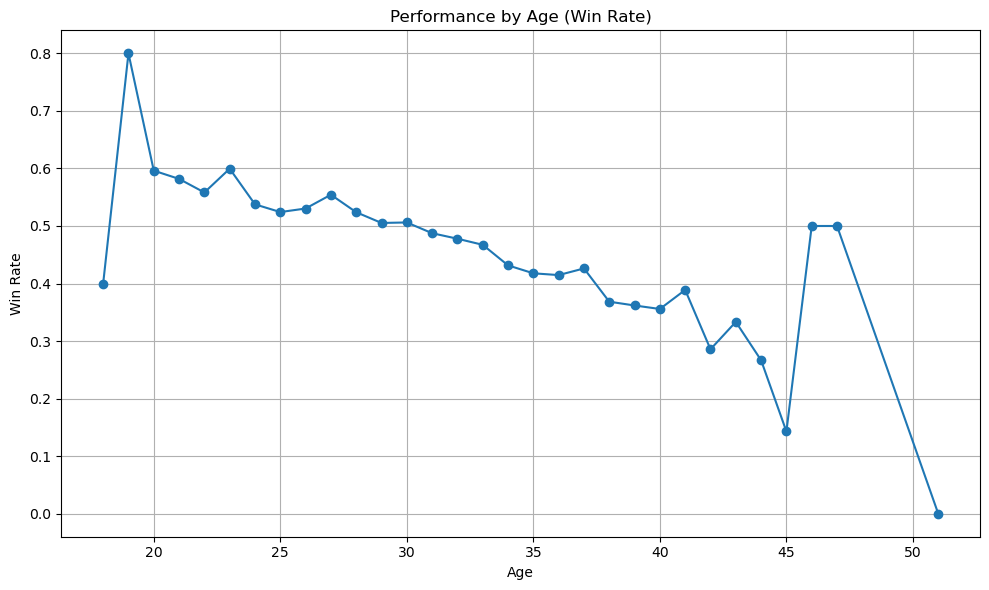

In [1210]:
performance_by_age_chart_path = "images/chart-2.png"

plt.figure(figsize=(10, 6))
plt.plot(performance_by_age["age"], performance_by_age["win_rate"], marker="o")
plt.xlabel("Age")
plt.ylabel("Win Rate")
plt.title("Performance by Age (Win Rate)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Average career length

In [1211]:
df = raw_ufc_details.copy()

In [1212]:
red_fighters = df[["r_id", "r_name", "date"]].rename(columns={
    "r_id": "fighter_id",
    "r_name": "fighter_name"
})

blue_fighters = df[["b_id", "b_name", "date"]].rename(columns={
    "b_id": "fighter_id",
    "b_name": "fighter_name"
})

all_fighters = pd.concat([red_fighters, blue_fighters], ignore_index=True)

In [1213]:
career_dates = all_fighters.groupby("fighter_id")["date"].agg(["min", "max"]).reset_index()
career_dates["career_length_days"] = (career_dates["max"] - career_dates["min"]).dt.days
career_dates["career_length_years"] = career_dates["career_length_days"] / 365

In [1214]:
average_career_length_years = round(career_dates["career_length_years"].mean(), 2)
report_data["average_career_length_years"] = float(average_career_length_years)

# 2. Analytical & Comparative Reports

> These go deeper and highlight analytical thinking, correlations, and behavior patterns.

## What Influences a Fight Outcome?

#### Data preparing

In [1215]:
df_fight_outcome = ufc_fights.copy()

# Merge to bring in the blue fighter's reach (b_id)
df_fight_outcome = df_fight_outcome.merge(
    ufc_fighters[['id', 'reach', 'height', 'weight']], 
    how='left', 
    left_on='b_id', 
    right_on='id'
).rename(columns={'reach': 'b_reach', 'height': 'b_height', 'weight': 'b_weight'}).drop(columns=['id'])

# Merge to bring in the red fighter's reach (r_id)
df_fight_outcome = df_fight_outcome.merge(
    ufc_fighters[['id', 'reach', 'height', 'weight']], 
    how='left', 
    left_on='r_id', 
    right_on='id'
).rename(columns={'reach': 'r_reach', 'height': 'r_height', 'weight': 'r_weight'}).drop(columns=['id'])

# Dropping unknown reaches, heights and weights from any of the fighters
df_fight_outcome = df_fight_outcome.dropna(subset=["r_reach", "b_reach", "b_height", "r_height", "r_weight", "b_weight"])

df_fight_outcome.reset_index()

,index,event_name,event_id,fight_id,r_name,r_id,b_name,b_id,division,title_fight,...,b_landed_clinch_per,b_landed_ground_per,winner_id,date,b_reach,b_height,b_weight,r_reach,r_height,r_weight
0,0,UFC 319: Du Plessis vs. Chimaev,421ccfc6ddb17958,82338ba457fbe87f,Tim Elliott,c96d9178c9ed9e62,Kai Asakura,d33da8a3d82bdb62,flyweight,0,...,0.0,0.0,c96d9178c9ed9e62,2025-08-16,175.26,172.72,56.70,167.64,170.18,56.70
1,1,UFC 319: Du Plessis vs. Chimaev,421ccfc6ddb17958,1d8dc0fb5d47357f,Chase Hooper,971246648e162f0d,Alexander Hernandez,262a7d06203657e6,lightweight,0,...,0.0,23.0,262a7d06203657e6,2025-08-16,182.88,175.26,70.31,187.96,185.42,70.31
2,2,UFC 319: Du Plessis vs. Chimaev,421ccfc6ddb17958,5b880d10b0ed7acc,Gerald Meerschaert,6ac9bc2953c47345,Michal Oleksiejczuk,0d65c432720accb9,middleweight,0,...,0.0,52.0,0d65c432720accb9,2025-08-16,187.96,182.88,83.91,195.58,185.42,83.91
3,3,UFC 319: Du Plessis vs. Chimaev,421ccfc6ddb17958,42585ce706c086de,Geoff Neal,b997be68943010fc,Carlos Prates,7ee0fd831c0fe7c3,welterweight,0,...,0.0,0.0,7ee0fd831c0fe7c3,2025-08-16,198.12,185.42,77.11,190.50,180.34,77.11
4,4,UFC 319: Du Plessis vs. Chimaev,421ccfc6ddb17958,12cedec11b37ddc0,Dricus Du Plessis,0d7b51c9d2649a6e,Khamzat Chimaev,767755fd74662dbf,middleweight,1,...,0.0,67.0,767755fd74662dbf,2025-08-16,190.50,187.96,83.91,193.04,185.42,83.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7049,8006,UFC Fight Night: Jedrzejczyk vs Penne,194fc025f9355db6,951ccd0041bd1700,Nick Hein,2816ced060a21be3,Lukasz Sajewski,fb41432b622992a9,lightweight,0,...,3.0,0.0,2816ced060a21be3,2015-06-20,180.34,172.72,70.31,167.64,167.64,70.31
7050,8007,UFC Fight Night: Jedrzejczyk vs Penne,194fc025f9355db6,447462bc8e540f10,Makwan Amirkhani,87a1dc546b1c5caf,Masio Fullen,4638cc6479cc0afe,featherweight,0,...,0.0,0.0,87a1dc546b1c5caf,2015-06-20,177.80,177.80,65.77,182.88,177.80,65.77
7051,8008,UFC Fight Night: Jedrzejczyk vs Penne,194fc025f9355db6,0b98d84a2795f7f8,Mairbek Taisumov,8f5c8850b2484173,Alan Patrick,cd7763bcadb5d4c8,lightweight,0,...,11.0,0.0,8f5c8850b2484173,2015-06-20,187.96,180.34,70.31,185.42,175.26,70.31
7052,8009,UFC Fight Night: Jedrzejczyk vs Penne,194fc025f9355db6,08cbd4c521831adf,Piotr Hallmann,a3be148af5c7b088,Magomed Mustafaev,31d7446b184e3305,lightweight,0,...,33.0,0.0,31d7446b184e3305,2015-06-20,180.34,172.72,70.31,180.34,175.26,70.31


### Correlation between height/reach and win probability

In [1216]:
height_diff = df_fight_outcome["r_height"] - df_fight_outcome["b_height"]
reach_diff = df_fight_outcome["r_reach"] - df_fight_outcome["b_reach"]
is_red_win = df_fight_outcome["winner_id"] == df_fight_outcome["r_id"]

In [1217]:
df_corr = pd.DataFrame({
    "height_diff": height_diff,
    "reach_diff": reach_diff,
    "is_red_win": is_red_win.astype(int)  # True/False -> 1/0
})

#### Evaluate correlation

In [1218]:
correlation_matrix = df_corr.corr()

correlation_matrix

,height_diff,reach_diff,is_red_win
height_diff,1.000000,0.622085,0.040826
reach_diff,0.622085,1.000000,0.053458
is_red_win,0.040826,0.053458,1.000000


In [1219]:
corr_result = correlation_matrix["is_red_win"].sort_values(ascending=False)

In [1220]:
influences_fight_outcome = (
    f"Based on the data, reach difference shows a correlation of {corr_result['reach_diff']:.3f} "
    f"with winning probability, while height difference shows a correlation of {corr_result['height_diff']:.3f}. "
    "This suggests that reach has a slightly higher influence on fight outcomes than height, although both "
    "correlations are weak and should not be considered strong predictors."
)

print(influences_fight_outcome)

report_data["influences_fight_outcome"] = influences_fight_outcome

Based on the data, reach difference shows a correlation of 0.053 with winning probability, while height difference shows a correlation of 0.041. This suggests that reach has a slightly higher influence on fight outcomes than height, although both correlations are weak and should not be considered strong predictors.


### Does making weight increase win chances?

> Fighters who cut weight correctly can have a psychological and physical advantage (even if temporary) over those who miss weight, or at least, they don't suffer the penalties.

### Do fighters coming off a win have a higher chance of winning again?

#### Creating the won_previous information

In [1221]:
# 1. First, transform each fight into two rows (red and blue corner) with generic columns
# including the 'won' column
red_df = df_fight_outcome[["date", "r_id", "winner_id"]].rename(
    columns={"r_id": "fighter_id"}
)
red_df["won"] = red_df["winner_id"] == red_df["fighter_id"]

blue_df = df_fight_outcome[["date", "b_id", "winner_id"]].rename(
    columns={"b_id": "fighter_id"}
)
blue_df["won"] = blue_df["winner_id"] == blue_df["fighter_id"]

# Concatenate both corners into a single dataframe
full_fighter_df = pd.concat([red_df, blue_df], ignore_index=True)

# 2. Sort by fighter and fight date
full_fighter_df = full_fighter_df.sort_values(by=["fighter_id", "date"])

# 3. Create 'won_previous' column by shifting the 'won' column per fighter
full_fighter_df["won_previous"] = full_fighter_df.groupby("fighter_id")["won"].shift(1)

# 4. Fill first fight with False since there is no previous fight
full_fighter_df["won_previous"] = full_fighter_df["won_previous"].astype("boolean").fillna(False)

#### Evaluating the won_previous rate

In [1222]:
win_rate_after_win = full_fighter_df[full_fighter_df["won_previous"] == True]["won"].mean()
win_rate_after_loss = full_fighter_df[full_fighter_df["won_previous"] == False]["won"].mean()

report_data["win_rate_previous_fight_result"] = {}
report_data["win_rate_previous_fight_result"]["won"] = f"{win_rate_after_win:.2%}"
report_data["win_rate_previous_fight_result"]["lost"] = f"{win_rate_after_loss:.2%}"

print(f"Win rate after winning previous fight: {win_rate_after_win:.2%}")
print(f"Win rate after losing previous fight: {win_rate_after_loss:.2%}")

Win rate after winning previous fight: 51.43%
Win rate after losing previous fight: 47.10%


## Performance Metrics Impact

In [1223]:
report_data["performance_metrics"] = {}

### Significant Strikes

In [1224]:
field = "sig_str_landed"
# Step 1: Identify who landed more significant strikes
df_fight_outcome["more_strikes"] = df_fight_outcome.apply(
    lambda row: row["r_id"] if row["r_" + field] > row["b_" + field]
    else (row["b_id"] if row["b_" + field] > row["r_" + field] else None),
    axis=1
)

# Step 2: Did the fighter with more strikes win?
df_fight_outcome["more_strikes_won"] = df_fight_outcome["winner_id"] == df_fight_outcome["more_strikes"]

# Step 3: Calculate win rate
win_rate_strikes = df_fight_outcome["more_strikes_won"].mean()

report_data["performance_metrics"]["strikes"] = round(win_rate_strikes * 100, 2)

print(f"Win rate when landing more significant strikes: {win_rate_strikes:.2%}")


Win rate when landing more significant strikes: 76.51%


### Takedowns landed

In [1225]:
field = "td_landed"
# Step 1: Identify who landed more significant strikes
df_fight_outcome["more_tds"] = df_fight_outcome.apply(
    lambda row: row["r_id"] if row["r_" + field] > row["b_" + field]
    else (row["b_id"] if row["b_" + field] > row["r_" + field] else None),
    axis=1
)

# Step 2: Did the fighter with more takedowns win?
df_fight_outcome["more_tds_won"] = df_fight_outcome["winner_id"] == df_fight_outcome["more_tds"]

# Step 3: Calculate win rate
win_rate_tkds = df_fight_outcome["more_tds_won"].mean()

report_data["performance_metrics"]["takedowns"] = round(win_rate_tkds * 100, 2)

print(f"Win rate when landing more takedowns: {win_rate_tkds:.2%}")

Win rate when landing more takedowns: 44.27%


### Submission attempts

In [1226]:
field = "sub_att"
# Step 1: Identify who landed more significant submission attempts
df_fight_outcome["more_sub_atts"] = df_fight_outcome.apply(
    lambda row: row["r_id"] if row["r_" + field] > row["b_" + field]
    else (row["b_id"] if row["b_" + field] > row["r_" + field] else None),
    axis=1
)

# Step 2: Did the fighter with more submission attempts win?
df_fight_outcome["more_subs_att_won"] = df_fight_outcome["winner_id"] == df_fight_outcome["more_sub_atts"]

# Step 3: Calculate win rate
win_rate_subs_atts = df_fight_outcome["more_subs_att_won"].mean()

report_data["performance_metrics"]["submissions"] = round(win_rate_subs_atts * 100, 2)

print(f"Win rate when landing more submission attempts: {win_rate_subs_atts:.2%}")

Win rate when landing more submission attempts: 27.05%


## Rivalries & Rematches

In [1227]:
df_rivalries_and_rematches = raw_ufc_details.copy()
df_rivalries = ufc_fights.copy()

### Timeline of fights between the same opponents
> For the sake of simplicity I got the 5 fight matches with the most rematches

In [1228]:
# Step 1: Create unique key for each pair of opponents
df_rivalries["pair_key"] = df_rivalries.apply(
    lambda x: tuple(sorted([x["r_id"], x["b_id"]])),
    axis=1
)

# Step 2: Counting fights between pairs
pair_counts = (
    df_rivalries.groupby("pair_key")["fight_id"]
        .count()
        .reset_index(name="num_fights")
)

# Step 3: Select the 5 pairs with the most number of rematches
top_5_pairs = pair_counts.sort_values("num_fights", ascending=False).head(5)["pair_key"]

# Step 4: Filter only those rivalries
df_top_rivalries = df_rivalries[df_rivalries["pair_key"].isin(top_5_pairs)].copy()

# Step 5: Sort chronologically
df_top_rivalries["date"] = pd.to_datetime(df_top_rivalries["date"])
df_top_rivalries = df_top_rivalries.sort_values(["pair_key", "date"])

# Step 6: Create a "fight #" identifier within the rivalry
df_top_rivalries["fight_number"] = df_top_rivalries.groupby("pair_key").cumcount() + 1

# Step 7: Create winner_name column to facilitate visualization on dashboard

df_top_rivalries["winner_name"] = np.where(
    df_top_rivalries["winner_id"] == df_top_rivalries["r_id"],
    df_top_rivalries["r_name"],
    np.where(
        df_top_rivalries["winner_id"] == df_top_rivalries["b_id"],
        df_top_rivalries["b_name"],
        "Draw / No Contest"
    )
)

# Step 8: Organize columns for visualization

cols_organization = [
    "pair_key", "fight_number", "date", "event_name",
     "r_name", "b_name", "winner_name", "method", "r_id", "b_id","winner_id"
]

df_top_rivalries = df_top_rivalries[cols_organization]

df_top_rivalries

,pair_key,fight_number,date,event_name,r_name,b_name,winner_name,method,r_id,b_id,winner_id
7560,"(0aa92558424ced9e, a390eb8a9b2df298)",1,2003-06-06,UFC 43: Meltdown,Randy Couture,Chuck Liddell,Randy Couture,KO/TKO,0aa92558424ced9e,a390eb8a9b2df298,0aa92558424ced9e
7498,"(0aa92558424ced9e, a390eb8a9b2df298)",2,2005-04-16,UFC 52: Couture vs Liddell 2,Chuck Liddell,Randy Couture,Chuck Liddell,KO/TKO,a390eb8a9b2df298,0aa92558424ced9e,a390eb8a9b2df298
7437,"(0aa92558424ced9e, a390eb8a9b2df298)",3,2006-02-04,UFC 57: Liddell vs Couture 3,Chuck Liddell,Randy Couture,Chuck Liddell,KO/TKO,a390eb8a9b2df298,0aa92558424ced9e,a390eb8a9b2df298
7510,"(2a542ee8a8b83559, 3738e68d2261e60f)",1,2005-02-05,UFC 51: Super Saturday,Andrei Arlovski,Tim Sylvia,Andrei Arlovski,Submission,3738e68d2261e60f,2a542ee8a8b83559,3738e68d2261e60f
7416,"(2a542ee8a8b83559, 3738e68d2261e60f)",2,2006-04-15,UFC 59: Reality Check,Tim Sylvia,Andrei Arlovski,Tim Sylvia,KO/TKO,2a542ee8a8b83559,3738e68d2261e60f,2a542ee8a8b83559
7383,"(2a542ee8a8b83559, 3738e68d2261e60f)",3,2006-07-08,UFC 61: Bitter Rivals,Tim Sylvia,Andrei Arlovski,Tim Sylvia,Decision - Unanimous,2a542ee8a8b83559,3738e68d2261e60f,2a542ee8a8b83559
7547,"(621a6c59f88a44fe, 73c7cfa551289285)",1,2004-01-31,UFC 46: Supernatural,BJ Penn,Matt Hughes,BJ Penn,Submission,73c7cfa551289285,621a6c59f88a44fe,73c7cfa551289285
7355,"(621a6c59f88a44fe, 73c7cfa551289285)",2,2006-09-23,UFC 63: Hughes vs Penn,Matt Hughes,BJ Penn,Matt Hughes,KO/TKO,621a6c59f88a44fe,73c7cfa551289285,621a6c59f88a44fe
6551,"(621a6c59f88a44fe, 73c7cfa551289285)",3,2010-11-20,UFC 123: Rampage vs Machida,Matt Hughes,BJ Penn,BJ Penn,KO/TKO,621a6c59f88a44fe,73c7cfa551289285,73c7cfa551289285
2362,"(792be9a24df82ed6, aa72b0f831d0bfe5)",1,2020-12-12,UFC 256: Figueiredo vs. Moreno,Deiveson Figueiredo,Brandon Moreno,Draw / No Contest,Decision - Majority,aa72b0f831d0bfe5,792be9a24df82ed6,NaN


#### Rivalry report object creation

In [1229]:
# Group rivalries by unique pair of fighters
rivalries_grouped = df_top_rivalries.groupby("pair_key")

# This list will store the final structured rivalry data for the template
rivalries = []

# Counter to assign image numbers sequentially
fighter_image_counter = 1

# Counter to assign poster image sequentially
poster_image_counter = 1

# Iterate over each rivalry (grouped by 'pair_key')
for pair_key, group in rivalries_grouped:
    
    # Sort fights within each rivalry by their fight number (chronological order)
    group_sorted = group.sort_values("fight_number")
    
    # Extract fighter names from the first fight in the sorted group
    r_id = group_sorted.iloc[0]["r_id"]
    b_id = group_sorted.iloc[0]["b_id"]
    r_name = group_sorted.iloc[0]["r_name"]
    b_name = group_sorted.iloc[0]["b_name"]

    
    # Count how many times the red corner fighter won
    r_wins = (group_sorted["winner_id"] == r_id).sum()
    
    # Count how many times the blue corner fighter won
    b_wins = (group_sorted["winner_id"] == b_id).sum()

    # Build a list of fights for this rivalry
    fights_list = []
    for _, row in group_sorted.iterrows():
        # Convert each row to a dictionary
        fight_data = row.to_dict()
        
        # Format the date to 'YYYY-MM-DD' to remove unnecessary time information
        fight_data["date"] = row["date"].strftime("%Y-%m-%d")

        fight_data["poster"] = f"images/rivalry_poster_fight_{poster_image_counter}.jpg"
        
        # Add this fight to the rivalry's fight list
        fights_list.append(fight_data)
        poster_image_counter += 1
    
    # Store the rivalry information with aggregated wins, images, and detailed fights
    rivalries.append({
        "pair_key": pair_key,                  # Unique identifier for the rivalry
        "r_name": r_name,                       # Red corner fighter name
        "b_name": b_name,                       # Blue corner fighter name
        "r_wins": int(r_wins),                  # Total wins for red corner fighter
        "b_wins": int(b_wins),                  # Total wins for blue corner fighter
        "r_image": f"images/rivalry_{fighter_image_counter}.jpg",  # Sequential image for red fighter
        "b_image": f"images/rivalry_{fighter_image_counter + 1}.jpg",  # Sequential image for blue fighter
        "fights": fights_list                   # List of all fights in this rivalry
    })

    # Increment fighter image counter by 2 (one for each fighter)
    fighter_image_counter += 2
    
report_data["rivalries"] = rivalries
rivalries

[{'pair_key': ('0aa92558424ced9e', 'a390eb8a9b2df298'),
  'r_name': 'Randy Couture',
  'b_name': 'Chuck Liddell',
  'r_wins': 1,
  'b_wins': 2,
  'r_image': 'images/rivalry_1.jpg',
  'b_image': 'images/rivalry_2.jpg',
  'fights': [{'pair_key': ('0aa92558424ced9e', 'a390eb8a9b2df298'),
    'fight_number': 1,
    'date': '2003-06-06',
    'event_name': 'UFC 43: Meltdown',
    'r_name': 'Randy Couture',
    'b_name': 'Chuck Liddell',
    'winner_name': 'Randy Couture',
    'method': 'KO/TKO',
    'r_id': '0aa92558424ced9e',
    'b_id': 'a390eb8a9b2df298',
    'winner_id': '0aa92558424ced9e',
    'poster': 'images/rivalry_poster_fight_1.jpg'},
   {'pair_key': ('0aa92558424ced9e', 'a390eb8a9b2df298'),
    'fight_number': 2,
    'date': '2005-04-16',
    'event_name': 'UFC 52: Couture vs Liddell 2',
    'r_name': 'Chuck Liddell',
    'b_name': 'Randy Couture',
    'winner_name': 'Chuck Liddell',
    'method': 'KO/TKO',
    'r_id': 'a390eb8a9b2df298',
    'b_id': '0aa92558424ced9e',
    'winn

### Performance evolution across trilogies

In [1230]:
df_performance_evo_across_trilogies = raw_ufc_details.copy()

#### Create a column with a unique identifier for the pair of fighters

In [1231]:
# Create column with ordered names to identify the fight pair
df_performance_evo_across_trilogies["fighter_pair"] = df_performance_evo_across_trilogies.apply(
    lambda row: tuple(sorted([row["r_id"], row["b_id"]])),
    axis=1
)

#### Filter pairs that have fought 3 or more times (trilogies or more)

In [1232]:
# Count how many fights each pair had
pair_counts = df_performance_evo_across_trilogies["fighter_pair"].value_counts()

# Filter only pairs with 3 or more fights
trilogies_pairs = pair_counts[pair_counts >= 3].index.tolist()

# Filter original dataframe to keep only these fights
df_trilogies = df_performance_evo_across_trilogies[
    df_performance_evo_across_trilogies["fighter_pair"].isin(trilogies_pairs)
].copy()

#### Sort by date to analyze chronological evolution

In [1233]:
df_trilogies = df_trilogies.sort_values(by=["fighter_pair", "date"])

#### For each fight, identify the winner and create simple metrics for performance

* Who won
* Fight number of the trilogy (1, 2, 3, ...)
* Important statistics (e.g., significant strikes, takedowns, control)

In [1234]:
df_trilogies["match_number"] = df_trilogies.groupby("fighter_pair").cumcount() + 1

imp_stats_colums = [
    "fighter_pair",
    "date",
    "match_number",
    "winner_id",
    "r_id",
    "b_id",
    "r_name",
    "b_name",
    "r_total_str_landed",
    "b_total_str_landed",
    "r_td_landed",
    "b_td_landed",
    "r_ctrl",
    "b_ctrl"
]

imp_stats_df = df_trilogies[imp_stats_colums]

imp_stats_df["strikes_diff"] = abs(imp_stats_df["r_total_str_landed"] - imp_stats_df["b_total_str_landed"])
imp_stats_df["td_diff"] = abs(imp_stats_df["r_td_landed"] - imp_stats_df["b_td_landed"])
imp_stats_df["ctrl_diff"] = abs(imp_stats_df["r_ctrl"] - imp_stats_df["b_ctrl"])

/var/folders/y2/th9j6g7n1wgghjg95sgj0cqr0000gq/T/ipykernel_97586/236341316.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_stats_df["strikes_diff"] = abs(imp_stats_df["r_total_str_landed"] - imp_stats_df["b_total_str_landed"])
/var/folders/y2/th9j6g7n1wgghjg95sgj0cqr0000gq/T/ipykernel_97586/236341316.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_stats_df["td_diff"] = abs(imp_stats_df["r_td_landed"] - imp_stats_df["b_td_landed"])
/var/folders/y2/th9j6g7n1wgghjg95sgj0cqr0000gq/T/ipykernel_

#### Performance evolution across trilogies report object

In [1235]:
# Group duels by unique pair of fighters
trilogies_grouped = imp_stats_df.groupby("fighter_pair")

# This list will store the final structured duels data for the template
trilogies = []

# Counter to assign image numbers sequentially
image_counter = 1

# Iterate over each trilogy (grouped by 'fighter_pair')
for fighter_pair, group in trilogies_grouped:
    
    # Sort fights within each trilogy by their fight number (chronological order)
    group_sorted = group.sort_values("match_number")

    # Extract fighter ids from the first fight in the sorted group
    r_id = group_sorted.iloc[0]["r_id"]
    b_id = group_sorted.iloc[0]["b_id"]
    
    # Extract fighter names from the first fight in the sorted group
    r_name = group_sorted.iloc[0]["r_name"]
    b_name = group_sorted.iloc[0]["b_name"]
    
    # Count how many times the red corner fighter won
    r_wins = (group_sorted["winner_id"] == r_id).sum()
    
    # Count how many times the blue corner fighter won
    b_wins = (group_sorted["winner_id"] == b_id).sum()

    # Build a list of fights for this rivalry
    fights_list = []
    for _, row in group_sorted.iterrows():
        # Convert each row to a dictionary
        fight_data = row.to_dict()
        
        # Format the date to 'YYYY-MM-DD' to remove unnecessary time information
        fight_data["date"] = row["date"].strftime("%Y-%m-%d")
        
        # Add this fight to the rivalry's fight list
        fights_list.append(fight_data)
    
    # Store the rivalry information with aggregated wins, images, and detailed fights
    trilogies.append({
        "fighter_pair": fighter_pair,                          # Unique identifier for the duel
        "r_name": r_name,                                      # Red corner fighter name
        "b_name": b_name,                                      # Blue corner fighter name
        "r_wins": int(r_wins),                                 # Total wins for red corner fighter
        "b_wins": int(b_wins),                                 # Total wins for blue corner fighter
        "r_image": f"images/trilogy_{image_counter}.jpg",      # Sequential image for red fighter
        "b_image": f"images/trilogy_{image_counter + 1}.jpg",  # Sequential image for blue fighter
        "fights": fights_list                                  # List of all fights in this rivalry
    })

    # Increment image counter by 2 (one for each fighter)
    image_counter += 2
report_data["trilogies"] = trilogies[0:5]

## Generate HTML with reports

In [1243]:
def generate_ufc_report_html(output_file="generated/ufc_report.html"):
    env = Environment(loader=FileSystemLoader("./templates"))
    template = env.get_template("ufc_report.html")

    html = template.render(
        title="UFC Analytics",
        ufc_logo_url= "./images/UFC_Logo.png",
        kaggle_link = "https://www.kaggle.com/datasets/neelagiriaditya/ufc-datasets-1994-2025/data",
        github_link = "https://github.com/joaogouveia89/ufc-data-study-case",
        processed_date=human_readable_date(datetime.today()),
        data = report_data
    )

    with open(output_file, "w", encoding="utf-8") as f:
        f.write(html)

    print(f"Saved on {output_file}")

generate_ufc_report_html()

Saved on generated/ufc_report.html
